In [1]:
import numpy as np
import math 
import pylab as pyl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.optimize 
import scipy.ndimage as ndimage
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from numpy import mean, sqrt, square, arange

import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (12,8)

QUIET=False

#camera resolution in m
#cal = 9.0e-6
CAL = 7.4e-6

#number of scanning steps
N_SCAN_STEP = 30

#quadrupole skew rotation angle
#0 - normal quad, 45 - skew quad CW
#experimental
SKEW = 0.0

In [2]:
i = 1

root = '../examples/Normal_quad_scan_L2/'
filename = root + 'X111_YAG_'+str(i)+'_bkg_0.png'
filenamebg = root + 'X111_YAG_'+str(i)+'_img_0.png'

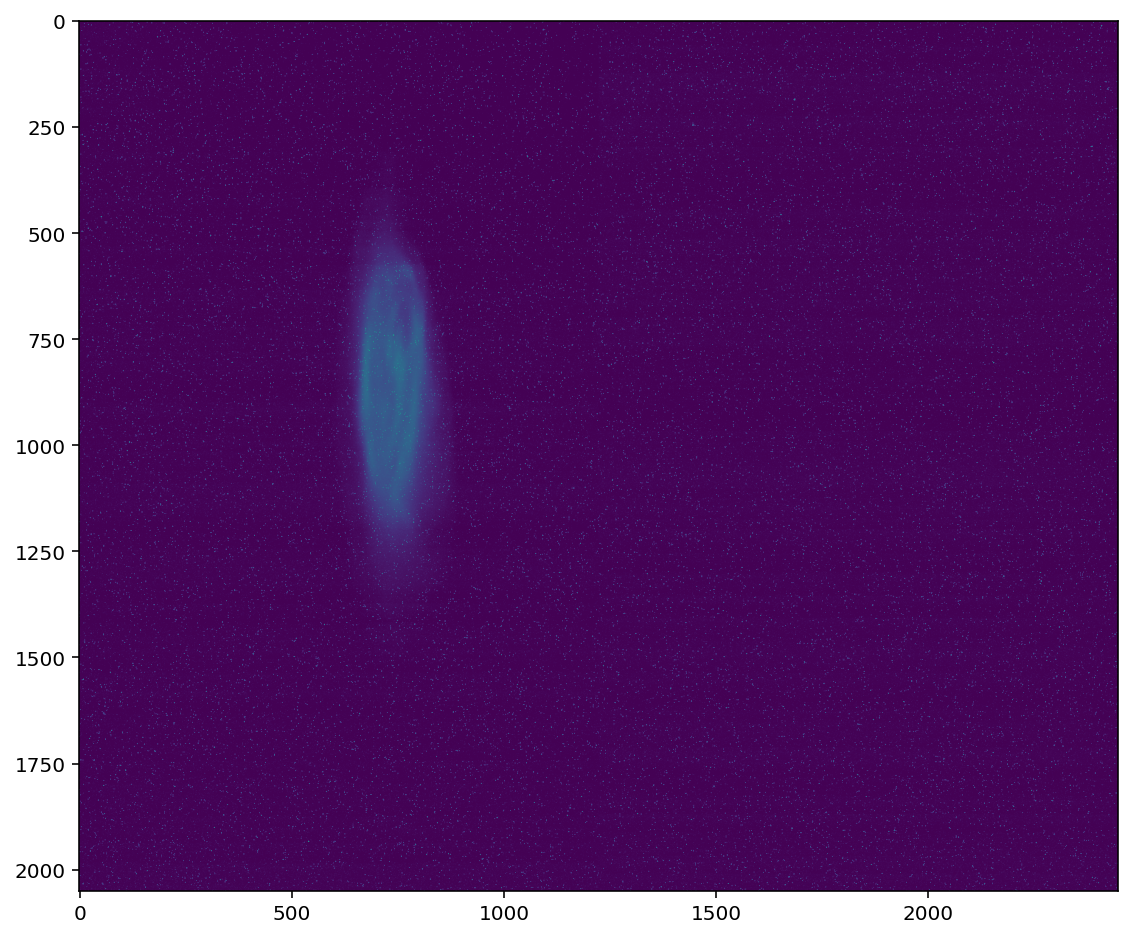

In [3]:
data = pyl.imread(filename)
plt.imshow(data)

# Functions

In [4]:
def Normalize(MyImage):
     w = np.where(MyImage<0.0)
     MyImage[w] = 0.0
     maxv=np.amax(MyImage)
     MyImage=MyImage/maxv
     return(MyImage)
    
def AutoCrop(MyImage, xbox,ybox):
#padding image with (0,0) on each side to avoid cropping error
     m = len(MyImage)
     MyImage = np.pad(MyImage,((m,m),(m,m)), 'constant')
     indexXmax=np.argmax(np.sum(MyImage,0))
     indexYmax=np.argmax(np.sum(MyImage,1))

     return(MyImage[indexYmax-ybox:indexYmax+ybox,indexXmax-xbox:indexXmax+xbox]) 

def ImageFit(MyImage,cal,plot=None):
    sumx=np.sum(MyImage,0)
    sumy=np.sum(MyImage,1)
    axisX=np.arange(len(sumx))
    axisY=np.arange(len(sumy))
    
    p2X= fitprofile(sumx, axisX)
    p2Y= fitprofile(sumy, axisY)
    
    if plot is None:
        plot = False
    if (plot != False):  
        print("Gaussian sigma x: ", cal*p2X[2])
        print("Gaussian sigma y: ", cal*p2Y[2])
    
        plt.figure()
        plt.title('Gaussian fit')
        plt.plot(axisX, sumx,'ob',alpha=0.45)
        plt.plot(axisY, sumy,'or',alpha=0.45)
        plt.legend(('X proj.','Y proj.'))
        plt.plot(axisX, dg(axisX,p2X),'--b',linewidth=3)
        plt.plot(axisY, dg(axisY,p2Y),'--r',linewidth=3)

        plt.xlabel('Size (px)')
        plt.ylabel('Axis projection')
        plt.tight_layout()
        plt.show()
    
    return p2X, p2Y

def dg(x,p0):
    rv=np.zeros(len(x))
    for i in range(len(x)):
        rv[i]=p0[3]+p0[1]*math.exp(-(x[i]-p0[0])*(x[i]-p0[0])/2/p0[2]/p0[2])
    return rv

def fitprofile(projection, axiscoord):
    
     xhist = projection
     xaxis = axiscoord
     indexXmax=xaxis[np.argmax(xhist)]
     bkg = np.mean(xhist[0:40])
     Xmax = np.max(xhist)
     p0x  = [indexXmax,Xmax, 1.,bkg]
     if not QUIET: 
            print(Xmax, indexXmax, bkg)
     ErrorFunc = lambda p0x,xaxis,xhist: dg(xaxis,p0x)-xhist
     p2,success = scipy.optimize.leastsq(ErrorFunc, p0x[:], args=(xaxis,xhist))
     
     return(p2)
    
def Denoise(MyImage):
     img = ndimage.gaussian_filter(MyImage, sigma=(5), order=0)
     return img    

def covR(data, semi_a0, semi_b0):
#Calculation of image covariance matrix as a function of mask radius R
#Find the image center-of-mass
    xbar, ybar, cov = image_raw_moments(data)
    center = [xbar, ybar]
    p2x,p2y = ImageFit(data,1.0)
    print("Image center is at: ", p2x[0], p2y[0])
    center = [p2x[0], p2y[0]]
#Define image size
    h, w = data.shape[:2]
    cov_array = np.zeros((N_SCAN_STEP,4))
#Loop over radius size (program core loop)
    for i in range (0,N_SCAN_STEP):
        factor = int( max(semi_a0,semi_b0) / min(semi_a0,semi_b0) )
        semi_a = semi_a0 + i*N_SCAN_STEP
        semi_b = semi_b0 + i*N_SCAN_STEP
        mask = create_elliptical_mask(h, w,center,semi_a,semi_b,SKEW)
        temp = data.copy()
        #zero all the points outside of region of interest
        temp[~mask] = 0.0
        xbart, ybart, covt = image_raw_moments(temp)
        cov_array[i,:] = np.ndarray.flatten(covt)
        print(semi_a,semi_b,i)
        #store calculated moments as a function of radius size for analysis
    return cov_array


def dcov_array_min(cov_array):
    #Calculate the correct radii for <xx>,<yy> and <xy> moments. The condition is min(d covR(R) / dR)
    #calculating derivatives
    divx = np.gradient(cov_array[:,0])
    divy = np.gradient(cov_array[:,3])
    divxy = np.abs(np.gradient(cov_array[:,1]))
    #calculating local minima for a not too noisy function
    minx = (np.diff(np.sign(np.diff(divx))) > 0).nonzero()[0] + 1
    miny = (np.diff(np.sign(np.diff(divy))) > 0).nonzero()[0] + 1
    minxy = (np.diff(np.sign(np.diff(divxy))) > 0).nonzero()[0] + 1
    if (len(minx)==0):
        minx = [0]
    if (len(miny)==0):
        miny = [0]
    if (len(minxy)==0):
        minxy = [0]
    if (QUIET != True):
        print("Resulting derivative masks:")
        print(minx, miny, minxy)
        
    #Picking the global minimum out of local minima
    nx = np.argmin(divx[minx])
    ny = np.argmin(divy[miny])
    #<xy> moment mask can not be less in size than the max(Rx,Ry). This is needed for non homogeneous beams
    maxr = np.max((minx[nx],miny[ny]))
     #   print "max(Rx,Ry): ", maxr
    if (maxr>np.max(minxy)): 
       maxr = np.max(minxy)
       print("Warning: <xy> may not be calculated correctly")
    w = np.where(minxy>=maxr)
    minxy = minxy[w]
    #    print 'Filtered minxy', minxy
    nxy = np.argmin(divxy[minxy])

    print(minx[nx],miny[ny],minxy[nxy])
    return minx[nx],miny[ny],minxy[nxy]        

def create_elliptical_mask(h, w, center=None, a = None, b = None, theta = None):
    if center is None: # use the center of the image
        center = [int(w/2), int(h/2)]
    if a is None: 
        a = min(center[0], center[1], w-center[0], h-center[1])
    if b is None: 
        b = min(center[0], center[1], w-center[0], h-center[1])
    if theta is None: 
        theta = 0.0
    #Create a meshgrid of a given area for fast calculation
    Y, X = np.ogrid[:h, :w]
    X = X - center[0]
    Y = Y - center[1]
    rtheta = np.radians(theta)
    R = np.array([
        [np.cos(rtheta), -np.sin(rtheta)],
        [np.sin(rtheta),  np.cos(rtheta)],
        ])
    Y, X = np.dot(R, np.array([Y, X]))
    dist_from_center = np.sqrt(b*b*(X)**2 + a*a*(Y)**2)
    #Create a circular mask
    mask = dist_from_center <= np.sqrt(a*a*b*b)
    return mask

def raw_moment(data, iord, jord):
    nrows, ncols = data.shape
#Create meshgrid for fast central moments (iord,jord) calculation
    y, x = np.mgrid[:nrows, :ncols]
    data = data * x**iord * y**jord
    return data.sum()

def image_raw_moments(data):
#Calculate <x>,<y>,<xx>,<xy> and <xy>
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    x_bar = m10 / data_sum
    y_bar = m01 / data_sum
    u11 = (raw_moment(data, 1, 1) - x_bar * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_bar * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_bar * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])
    print("Statistical moments sigma_x,sigma_y: ")
    print(np.sqrt(u20), np.sqrt(u02))
    return x_bar, y_bar, cov

def image_moments(data,semiaxis_a,semiaxis_b):
   
##    global radius0 
    radius0 = (semiaxis_a + semiaxis_b) / 2
##    global semi_a0, semi_b0
    semi_a0 = int(2*semiaxis_a)
    semi_b0 = int(2*semiaxis_b)
    print("Inital mask radius: ", radius0)
    h,v = data.shape[:2]
##    global step 
    step = int((h/2 - max(semi_a0,semi_b0))/N_SCAN_STEP)
    print("Step size is: ", step)

#Retrieve cov(R) data
    cov_array = covR(data, semi_a0, semi_b0)
#Find the image center-of-mass
    xbar, ybar, cov = image_raw_moments(data)
    center = [xbar, ybar]

    p2x,p2y = ImageFit(data,1.0)
    print("Image center is at: ", p2x[0], p2y[0])
    center = [p2x[0], p2y[0]]
#    ellipse = data.copy()
#    mask_ellipse = create_elliptical_mask(h,v,center,radius0,3*radius0,45.0)
#    ellipse[~mask_ellipse] = 0
#    plt.figure()
#    plt.imshow(ellipse)
#    plt.show()
    
#Calculate the correct radii for <xx>,<yy> and <xy> moments. The condition is min(d covR(R) / dR)
#    m = len(cov_array)
#Retrieve the positions of max(d covR(R) / dR)
#    nx, ny, nxy = dcov_array_max(cov_array)
#Radius is calculated as the location of derivative minimum
#    radiusX = radius0 + step*np.argmin(np.gradient(cov_array[nx:m-1,0])) + step*nx
#    radiusY = radius0 + step*np.argmin(np.gradient(cov_array[ny:m-1,3])) + step*ny
#    radiusXY = radius0 + step*np.argmin(np.abs(np.gradient(cov_array[nxy:m-1,1]))) + step*nxy

    minx,miny,minxy = dcov_array_min(cov_array)

    semi_aX = semi_a0 + step*minx
    semi_bX = semi_b0 + step*minx
    semi_aY = semi_a0 + step*miny
    semi_bY = semi_b0 + step*miny
    semi_aXY = semi_a0 + step*minxy
    semi_bXY = semi_b0 + step*minxy


    print("Mask ellipse X: ", semi_aX, semi_bX)
    print("Mask ellipse Y: ", semi_aY, semi_bY)
    print("Mask ellipse XY: ",semi_aXY, semi_bXY)
#Plotting covariance matrix elements for debugging
    plot_covarray(cov_array)
#Create masks for <xx>,<yy> and <xy> moments    
    maskX = create_elliptical_mask(h,v,center,semi_aX,semi_bX,SKEW)
    maskY = create_elliptical_mask(h,v,center,semi_aY,semi_bY,SKEW)
    maskXY = create_elliptical_mask(h,v,center,semi_aXY,semi_bXY,SKEW)
#Prepare three copies of masked data for final moments calculation    
    tempX = data.copy()
    tempY = data.copy()
    tempXY = data.copy()
    tempX[~maskX] = 0
    tempY[~maskY] = 0
    tempXY[~maskXY] = 0
#    plt.figure()
    
    fig, ax = plt.subplots(1)
    extent = (0, len(tempXY[:,0]), 0, len(tempXY[:,1]))
    tempXY = np.flip(tempXY,0)
    ax.imshow(Normalize(tempXY),extent=extent)
    cx = patches.Ellipse(center,2*semi_aX,2*semi_bX,SKEW,color='y',linewidth=3,fill=False)
    cy = patches.Ellipse(center,2*semi_aY,2*semi_bY,SKEW,color='g',linewidth=3,fill=False)
    cxy = patches.Ellipse(center,2*semi_aXY,2*semi_bXY,SKEW,color='m',linewidth=3,fill=False)
    ax.add_patch(cx)
    ax.add_patch(cy)
    ax.add_patch(cxy)
    plt.legend((cx,cy,cxy), (r'Mask $\langle xx \rangle$',r'Mask $\langle yy\rangle$',r'Mask $\langle xy\rangle$'))
    plt.xlabel('x (px)')
    plt.ylabel('y (px)')
    plt.tight_layout()
    plt.show()


#Final calculation
    xxt,yyt,covx = image_raw_moments(tempX)
    xxt,yyt,covy = image_raw_moments(tempY)
    xxt,yyt,covxy = image_raw_moments(tempXY)

    return covx[0,0],covy[1,1],covxy[0,1]


def plot_covarray(cov_array):
    plt.figure()
    #   plt.yscale('log')
    plt.plot(cov_array[:,0],'-',linewidth=3)
    plt.plot(np.abs(cov_array[:,1]),'-',linewidth=3)
    plt.plot(cov_array[:,3],'-',linewidth=3)
    plt.yscale('log')
    plt.ylabel('Central moment value (px*px)')
    plt.xlabel(r'Mask size + $d_0$ (px)')
    plt.legend((r'$\langle xx\rangle$',r'$\langle xy\rangle$',r'$\langle yy\rangle$'),loc=4)
    plt.tight_layout()

    plt.figure()
    plt.plot(np.gradient(cov_array[:,0]),'-',linewidth=3)
    plt.plot(np.gradient(cov_array[:,1]),'-',linewidth=3)
    plt.plot(np.gradient(cov_array[:,3]),'-',linewidth=3)
    plt.ylabel('Moment derivative (px)')
    plt.xlabel(r'Mask size + $d_0$ (px)')
    plt.legend((r'$\langle xx\rangle$',r'$\langle xy\rangle$',r'$\langle yy\rangle$'),loc=1)

    plt.tight_layout()
    #print "minimum at: ", np.argmin(np.abs(np.gradient(cov_array[3:,1])))
    plt.show()

# Test

In [6]:
data = pyl.imread(filename)
bg = pyl.imread(filenamebg)
data = data - bg
data = data[0:2000,0:2000]
data = Normalize(data)

181.2939 752 2.3778481
55.819614 824 1.4346079
Gaussian sigma x:  58.12898620528851
Gaussian sigma y:  213.58391353649188


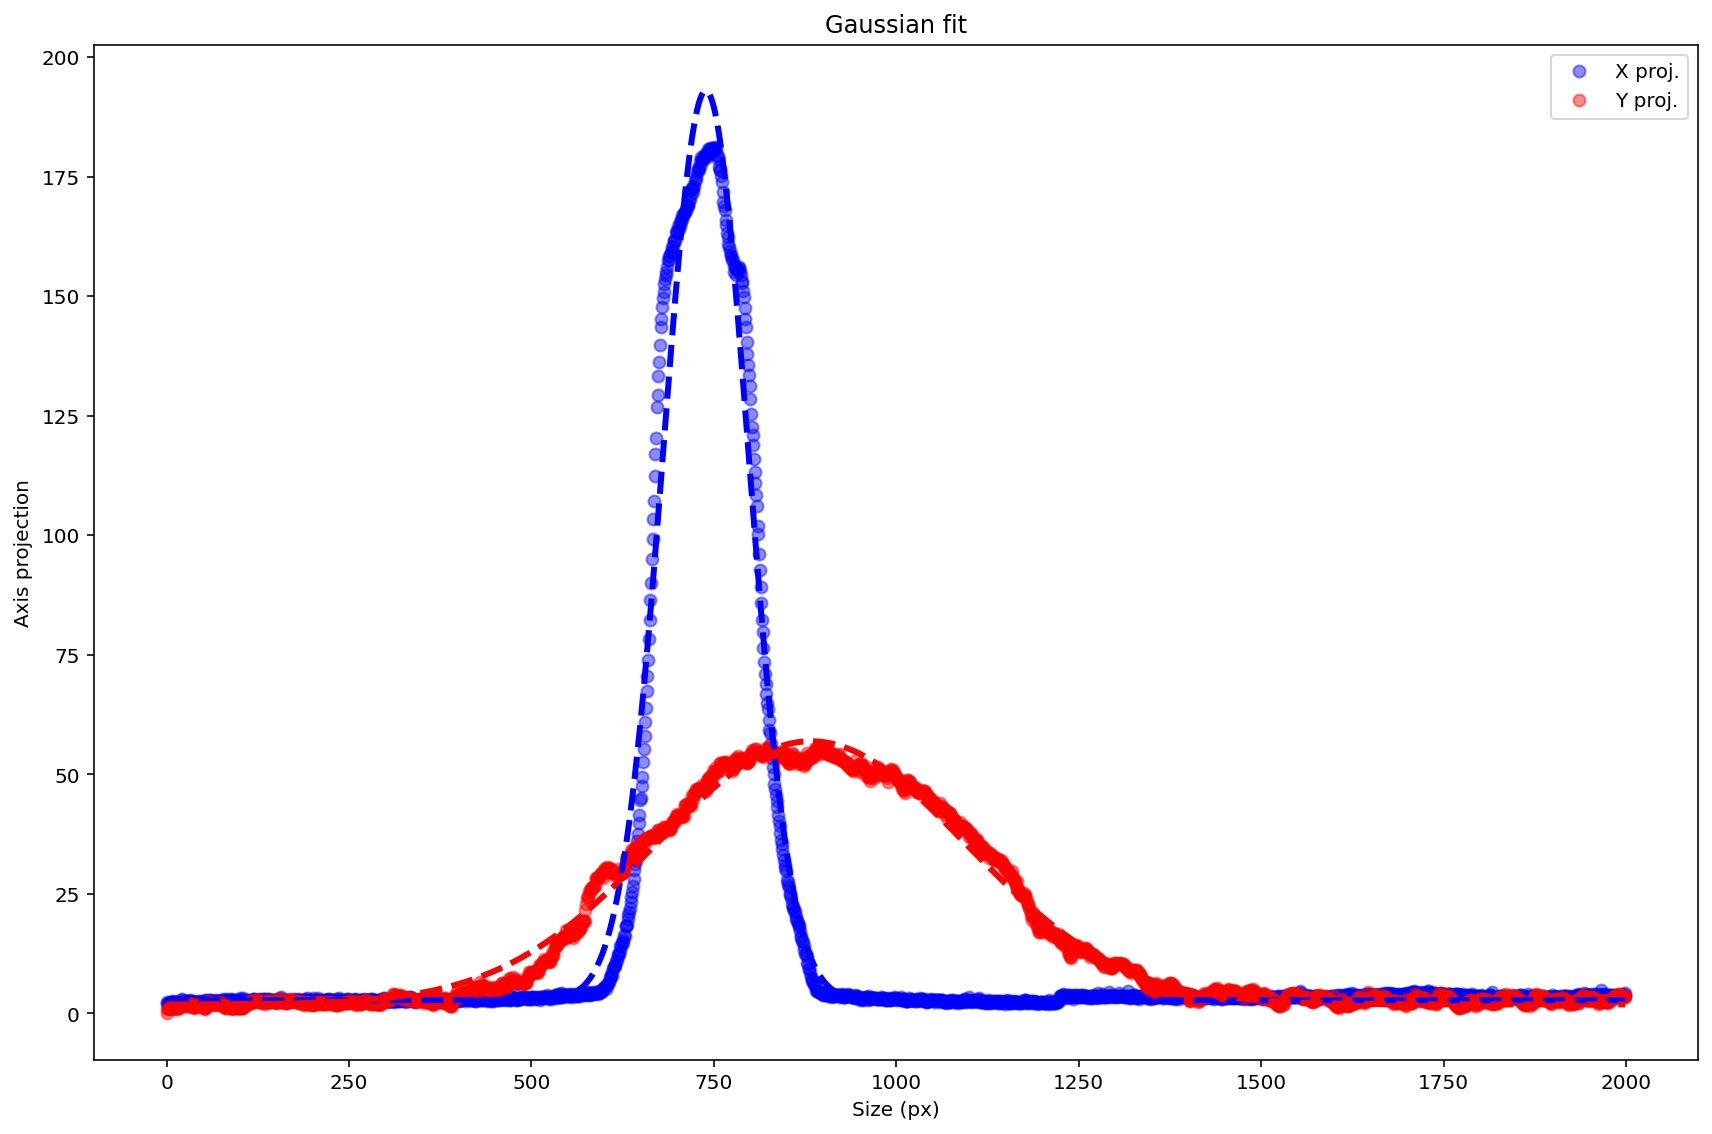

In [7]:
x,y = ImageFit(data,1.0,True)

In [8]:
print("Image center is at: ", int(x[0]),int(y[0]))
print("Gaussian fit sizes (px): ",int(x[2]),int(y[2]))
print("Gaussian fit sizes (m): ", CAL*x[2], CAL*y[2])
sigma_max = int(np.max((x[2],y[2])))
sigma_min = int(np.min((x[2],y[2])))

Image center is at:  738 883
Gaussian fit sizes (px):  58 213
Gaussian fit sizes (m):  0.000430154497919135 0.00158052096017004


In [9]:
#initial crop
box = int(4.7*sigma_max)
data = AutoCrop(data,box,box)
data = Denoise(data)



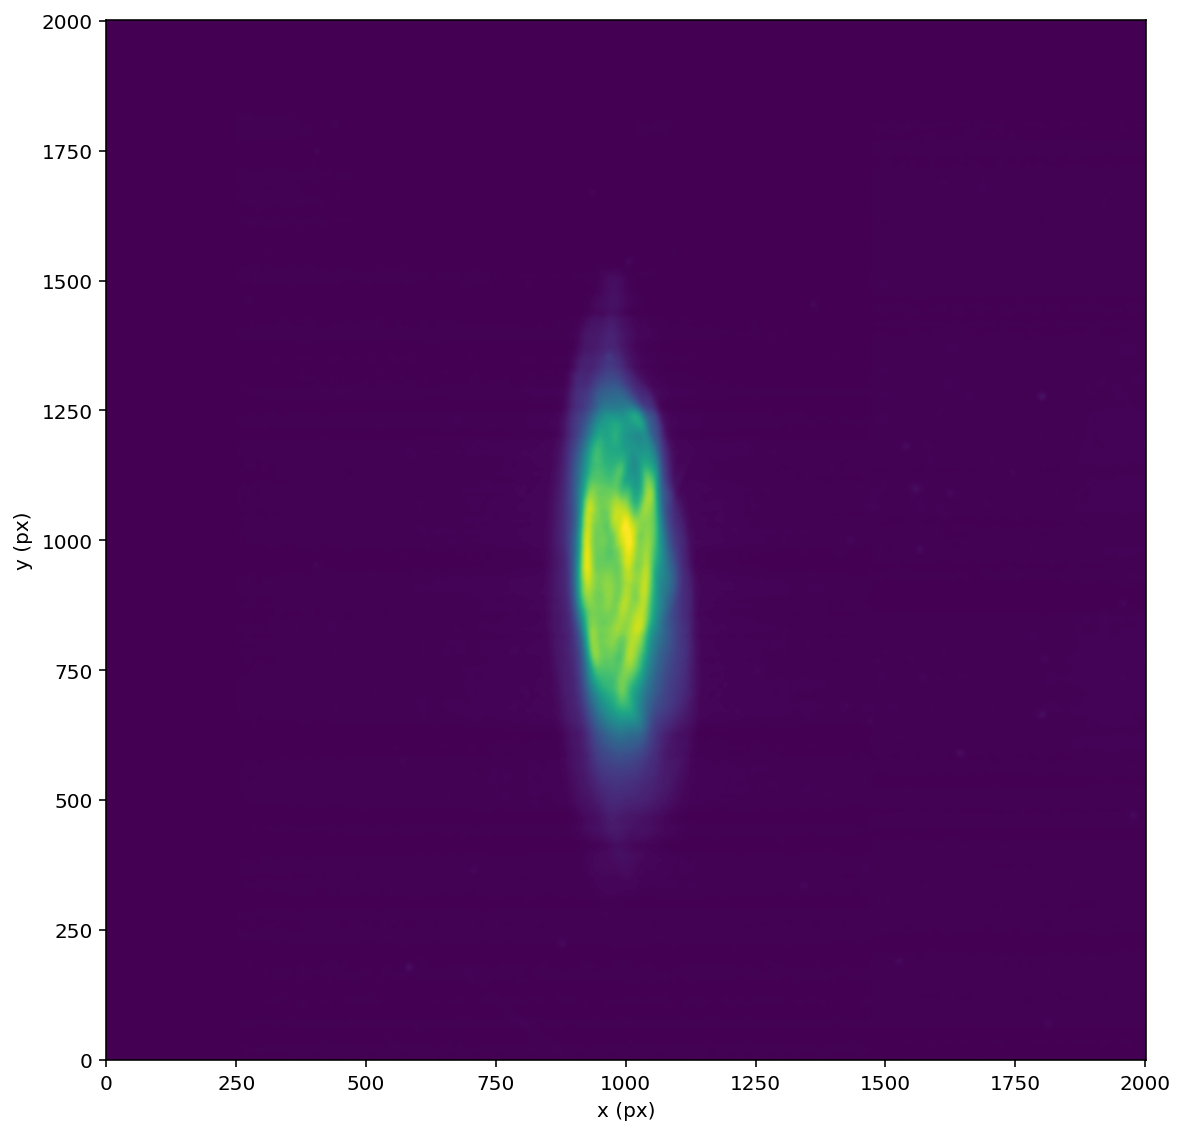

In [10]:
plt.figure()
extent = (0, len(data[:,0]), 0, len(data[:,1]))
plt.imshow(data,extent=extent)
plt.xlabel('x (px)')
plt.ylabel('y (px)')
plt.tight_layout()




Inital mask radius:  135.5
Step size is:  19
Statistical moments sigma_x,sigma_y: 
218.2751458509959 256.6562317724182
179.96736 996 0.0
54.55567 1075 0.0
Image center is at:  987.973882107477 1060.2509916163783


<ipython-input-4-0ece7414fa5f>:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y, X = np.dot(R, np.array([Y, X]))


Statistical moments sigma_x,sigma_y: 
48.49907108913238 175.76792172505318
116 426 0
Statistical moments sigma_x,sigma_y: 
52.23966791763177 181.85176045168694
146 456 1
Statistical moments sigma_x,sigma_y: 
53.94777911864939 186.77550704920452
176 486 2
Statistical moments sigma_x,sigma_y: 
55.419855731763434 190.11077064613482
206 516 3
Statistical moments sigma_x,sigma_y: 
57.039585858834286 192.2893049325126
236 546 4
Statistical moments sigma_x,sigma_y: 
58.94049757420283 194.18517806338372
266 576 5
Statistical moments sigma_x,sigma_y: 
61.1415800732598 195.79905730592432
296 606 6
Statistical moments sigma_x,sigma_y: 
63.69194903839198 197.20010775353643
326 636 7
Statistical moments sigma_x,sigma_y: 
66.57719035167582 198.55098158680116
356 666 8
Statistical moments sigma_x,sigma_y: 
69.83080469578371 200.09355511782306
386 696 9
Statistical moments sigma_x,sigma_y: 
73.35667413048488 201.86708980164636
416 726 10
Statistical moments sigma_x,sigma_y: 
77.36528184290007 203.8305

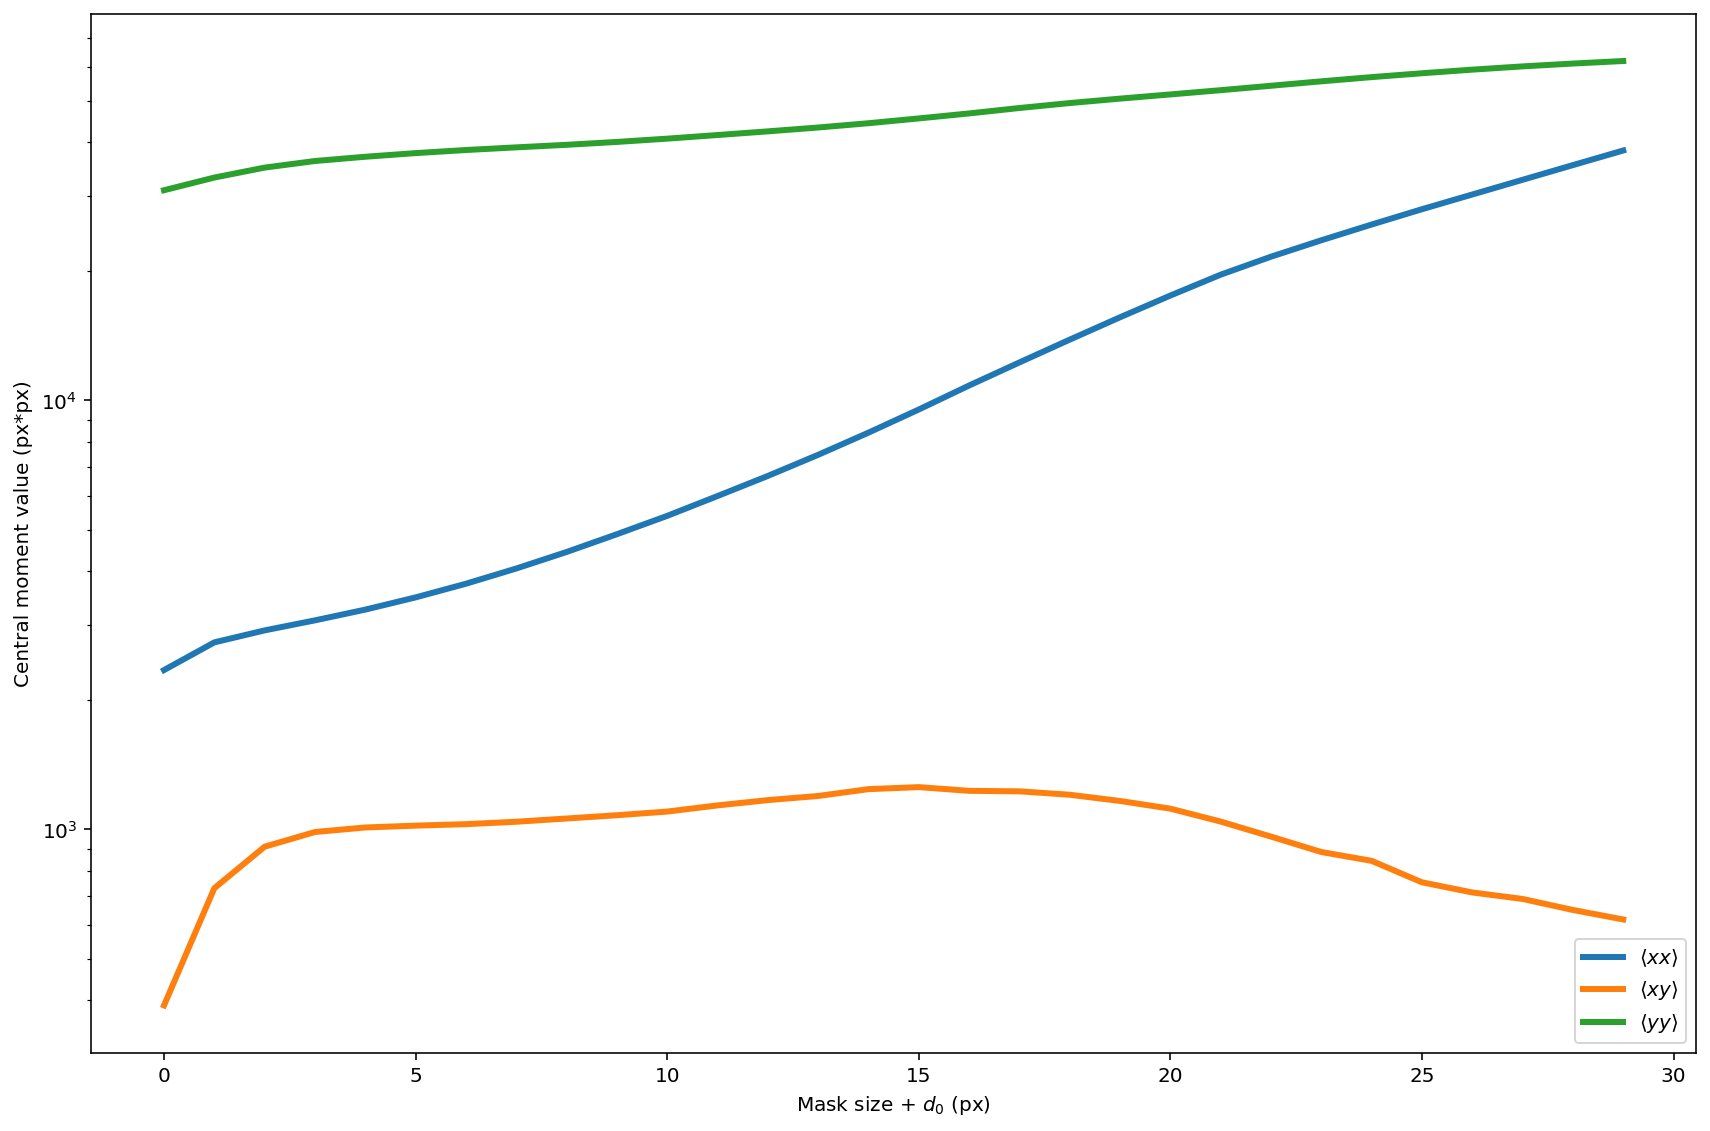

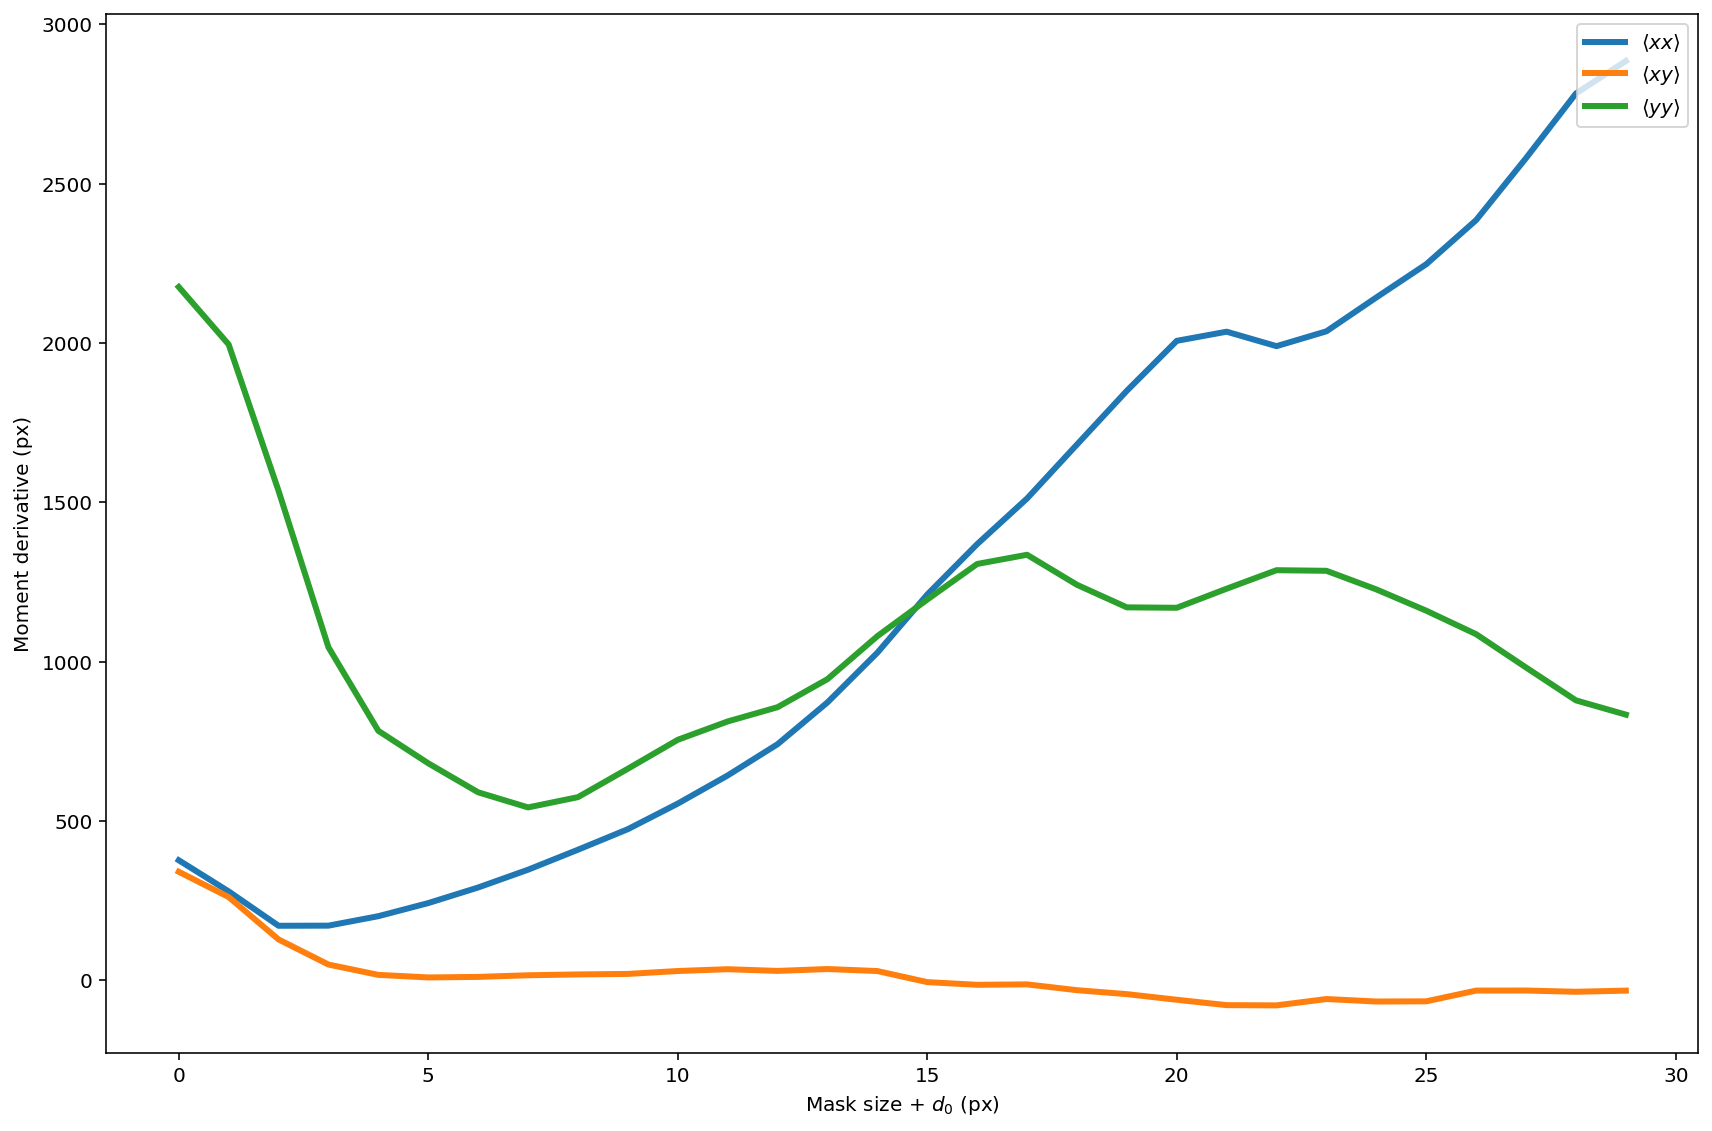

<ipython-input-4-0ece7414fa5f>:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y, X = np.dot(R, np.array([Y, X]))


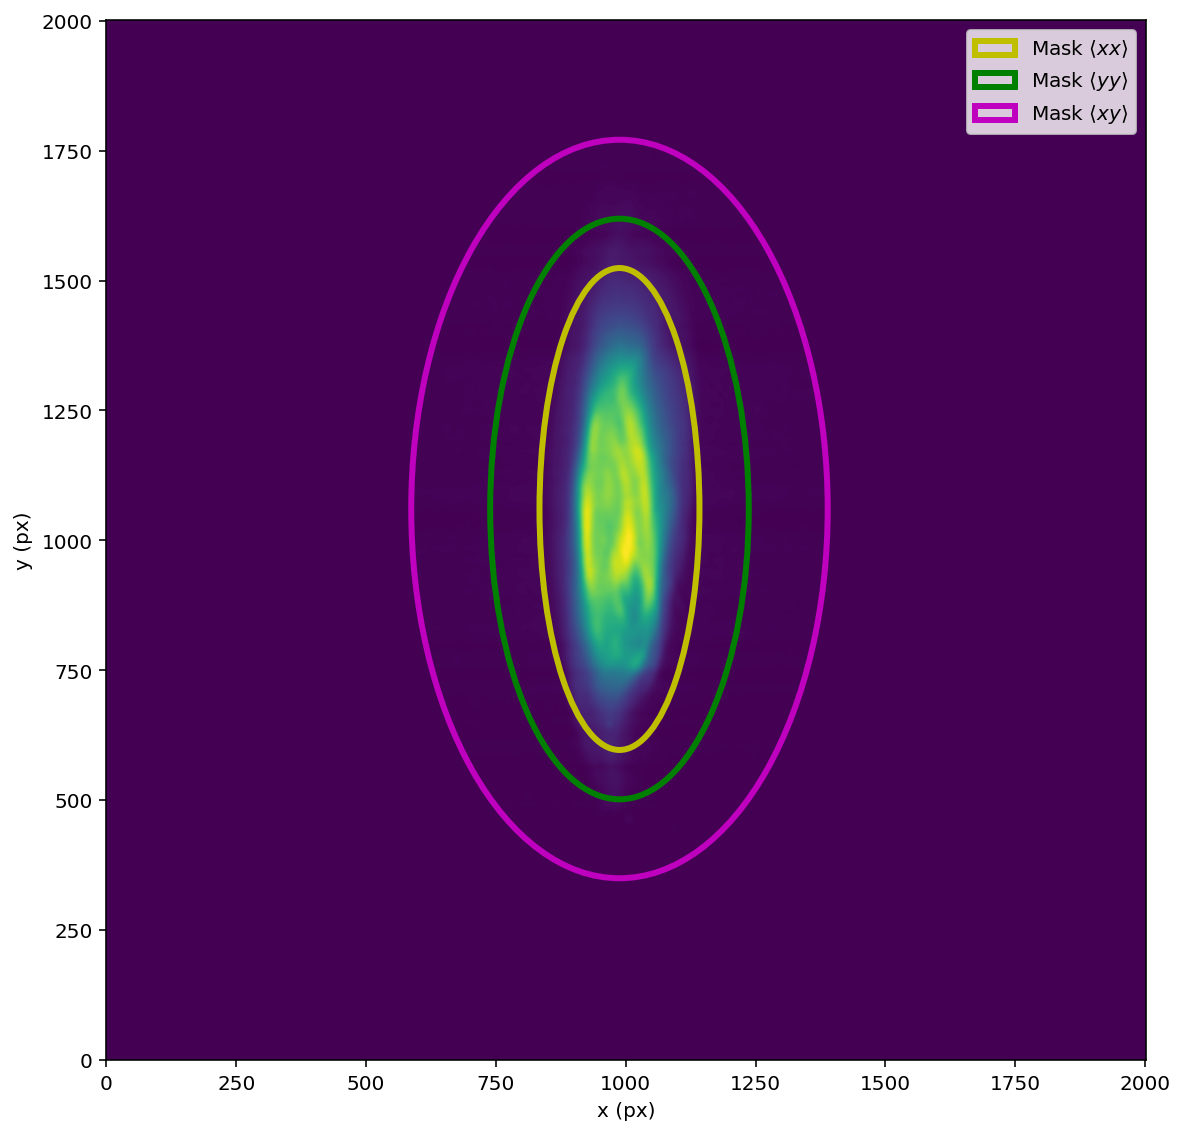

Statistical moments sigma_x,sigma_y: 
52.7810844438288 183.3218942560169
Statistical moments sigma_x,sigma_y: 
57.82647000505321 193.12545459296953
Statistical moments sigma_x,sigma_y: 
71.56299168958155 200.95903334186025


In [11]:
dcov_array_minxx, yy, xy = image_moments(data,int(x[2]),int(y[2]))